<a href="https://colab.research.google.com/github/Jair-RM/Modelacion-Financiera/blob/main/OC_SMF_Acciones%20Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manejo de Acciones

**Oliver Cuate**

*28 de febrero de 2025*

---

En este cuaderno le mostraré cómo usar [Pymoo](https://pymoo.org/) para resolver el problema clásico de portafolios (2 acciones).

## Obtener precios de acciones

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

hoy = pd.Timestamp.today()
inicio = hoy - pd.Timedelta(days=365*5)

print(inicio, hoy)

#tickers = ["^MXX", "BIMBOA.MX"]     # IPC MEXICO, BIMBO
tickers = ["KOF", "BTC-USD"]     # Coca-Cola FEMSA, Bitcoin USD

# inicio.strftime('%Y-%m-%d') # por si hay error
#datos = yf.download(ticker, start=inicio, end=hoy).copy() # todos los datos

datos = yf.download(tickers, start=inicio, end=hoy)['Close'].copy() # todos los datos

2020-03-01 18:28:19.668354 2025-02-28 18:28:19.668354
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


Vemos los datos

In [2]:
datos

Ticker,BTC-USD,KOF
Date,,
2020-03-01,8562.454102,NaN
2020-03-02,8869.669922,45.343884
2020-03-03,8787.786133,44.772968
2020-03-04,8755.246094,45.408222
2020-03-05,9078.762695,44.218132
...,...,...
2025-02-24,91418.171875,88.339996
2025-02-25,88736.171875,87.730003
2025-02-26,84347.023438,86.589996


## Calculamos los rendimientos

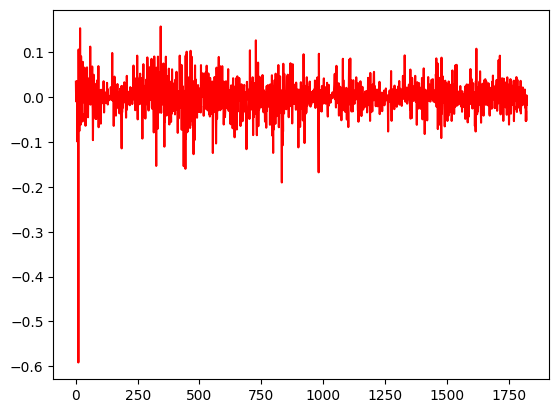

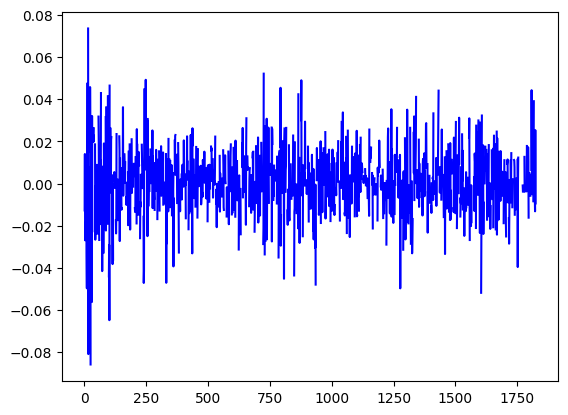

In [3]:
rend = (datos.values[1:]-datos.values[0:-1])/datos.values[1:]

plt.plot(range(rend.shape[0]),rend[:,0],'r')
plt.show()

plt.plot(range(rend.shape[0]),rend[:,1],'b')
plt.show()

In [4]:
r = rend.mean(axis=0)
r

array([0.00065943,        nan])

In [5]:
Cov = np.cov(rend, rowvar=False)
Cov

array([[0.00122867,        nan],
       [       nan,        nan]])

## Uso de Pymoo

Primero, hay que instalar Pymoo

In [6]:
!pip install -U pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.1 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=10d39ac79a034e6c29464803842eeab62cbf12ae4d0c46b2efebccde09aa37f9
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [7]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

class Portafolio(Problem):   # nombre que le queremos dar (Nombre de lo que es)
  def __init__(self, mu, cov):
    self.mu = mu
    self.cov = cov
    super().__init__(n_var=2, n_obj=2, n_ieq_constr=1, xl=0.0, xu=1.0)
                    # tenemos 2 activos
                    #          2 objetivos, minimizatr y maximizar
                    #                  restriccion es que la suma de pesos sea igual a 1
                    #                                   los pesos estan entre 0 y 1

  def _evaluate(self, x, out, *args, **kwargs):
    rendimiento = x @ self.mu
    riesgo = np.zeros(x.shape[0])
    for (i,w) in enumerate(x):
      riesgo[i] = np.sqrt(w @ self.cov @ w.T)

    out["F"] = [riesgo, -rendimiento]
    out["G"] = np.abs( np.sum(x, axis=1) - 1.0 ) - 0.1

problem = Portafolio(r,Cov)

algorithm = NSGA2(pop_size=50)   # poblacion de 50

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=True)


X, F = res.opt.get("X", "F")
F = F * [1, -1]

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Portafolios óptimos")
plt.scatter(Cov.diagonal() ** 0.5, r, facecolor="none", edgecolors="black", s=30, label="Activo")
#plt.legend(loc='best')
plt.legend(loc=7)
plt.xlabel("volatilidad")
plt.ylabel("rendimiento")
plt.show()

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |     12 |  0.000000E+00 |  0.2551687336 |             - |             -


AssertionError: Invalid progress was set by the TerminationCriterion.

In [ ]:
np.sum( res.X, axis=1 )

[Posición de la etiqueta](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)